# Collaborators
List your collaborators here:


---



## Initialization

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a PDF for gradescope submission.

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import platform
import random
from random import randrange
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import glob
from skimage.util import montage

np.random.seed(0)

# 1. Setup dataset

In this section we will download the dataset, unzip it and setup the paths to load images from.

This dataset is a tiny subset of [ImageNet](https://www.image-net.org/), a popular dataset for image classification.

This tiny dataset has **9538 training** images and **3856 test** images spanning **10 classes** {*fish, English-springer, cassette-player, chain-saw, church, French-horn, garbage-truck, gas-pump, golf-ball, parachute*} stored in the following directory structure:
```
dataset
  ---train
     ---class1
     ---class2
     ...
  ---test
     ---class1
     ---class2
     ...       
```
The data has been cleaned and we have provided dataloading functions below so you can directly use the dataset.


In [ ]:
if not os.path.exists('imagenette'):
  #!wget "https://drive.google.com/uc?export=download&id=1t3XtxcpVwZnKhsM95Q89MxYNlX5mj6aJ&confirm=t" -O /content/imagenette.zip
  !wget https://www.cs.cmu.edu/~deva/data/imagenette.zip -O imagenette.zip

--2025-09-13 22:07:17--  https://www.cs.cmu.edu/~deva/data/imagenette.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107288983 (102M) [application/zip]
Saving to: ‘imagenette.zip’

imagenette.zip      100%[===================>] 102.32M   200KB/s    in 12m 37s 

2025-09-13 22:19:55 (138 KB/s) - ‘imagenette.zip’ saved [107288983/107288983]

unzip:  cannot find or open /content/imagenette.zip, /content/imagenette.zip.zip or /content/imagenette.zip.ZIP.


In [7]:
!pwd
!unzip -qq "./imagenette.zip"

/Users/weichen/Documents/GitHub/cv-hw/16720/HW1_HOG


In [ ]:
train_data_path = '/content/imagenette/train'
test_data_path = '/content/imagenette/test'
train_image_paths = [] #to store image paths in list
test_image_paths  = []
classes           = []

#Get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(sum(train_image_paths,[]))
random.shuffle(train_image_paths)
test_image_paths = list(sum(test_image_paths,[]))
random.shuffle(test_image_paths)

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
def LoadData(img_paths,img_size,class_to_idx):
  n = len(img_paths)
  Images = np.zeros((n,img_size,img_size,3),dtype='uint8')
  Labels = np.zeros(n)
  for i in range(n):
    path = img_paths[i]
    Images[i,:,:,:] = np.asarray(Image.open(path).resize((img_size,img_size)));
    Labels[i] = class_to_idx[path.split('/')[-2]]
  return Images, Labels

# Load images as size 32x32; you can try with img_size = 64 to check if it improves the accuracy
img_size = 32
Train_Images, Train_Labels = LoadData(train_image_paths, img_size, class_to_idx)
Test_Images,   Test_Labels = LoadData( test_image_paths, img_size, class_to_idx)


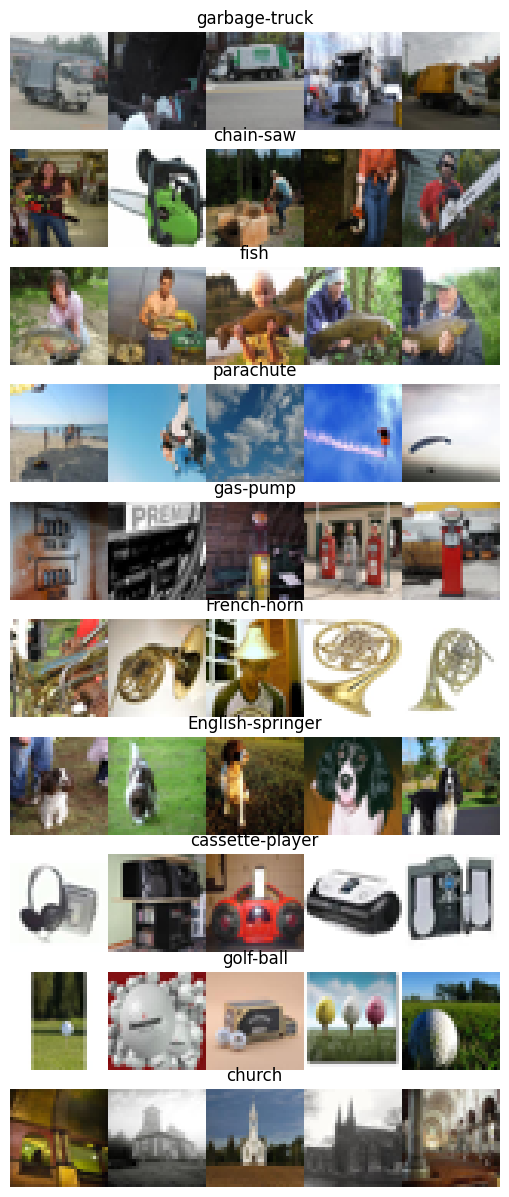

In [ ]:
# Visualize the first 5 images of the 10 classes
plt.figure(figsize=(15,15))
for i in range(10):
  plt.subplot(10,1,i+1)
  ind = np.nonzero(Train_Labels == i)[0]
  plt.imshow(montage(Train_Images[ind[:5],:],grid_shape=(1,5),channel_axis=3))
  plt.axis('off');
  plt.title(idx_to_class[i])

## Debug Flag
Set the debug flag to true when testing.
Setting the debug flag to true will let the dataloader use only 20% of the training dataset, which makes everything run faster. This will make testing the code easier.

Once you finish the coding part please make sure to change the flag to False and rerun all the cells. This will make the colab ready for submission.

In [ ]:
DEBUG = True

# Take a smaller subset of the training set for efficient execution of kNN
# We also create a small validation set

if DEBUG:
  num_train = 1900
  num_test =  700
else:
  num_train = 9000
  num_test =  3856

X_train = Train_Images[:num_train].reshape(num_train,-1).astype('float64')
y_train = Train_Labels[:num_train]
X_test  = Test_Images[:num_test].reshape(num_test,-1).astype('float64')
y_test  = Test_Labels[:num_test]

print('Train data shape: '  , X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: '   , X_test.shape)
print('Test labels shape: ' , y_test.shape)


Train data shape:  (1900, 3072)
Train labels shape:  (1900,)
Test data shape:  (700, 3072)
Test labels shape:  (700,)


## **Problem 3.1**

### (a) Define the KNearestNeighbor class

In [ ]:
from collections import Counter
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just
    memorizing the training data.
    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.
    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):

        # ===== your code here! =====

        # TODO:
        # Compute the l2 distance between the ith test image and the jth
        # training image, and store the result in dists[i, j].

        # ==== end of code ====

    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):

      # ===== your code here! =====

      # TODO:
      # Compute the l2 distance between the ith test point and all training
      # points, and store the result in dists[i, :].

      # ==== end of code ====

    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the l2 distance between each test point in X and each training point
    in self.X_train using no explicit loops.
    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # ===== your code here! =====

    # TODO:
    # Compute the l2 distance between all test points and all training
    # points without using any explicit loops, and store the result in
    # dists.
    #
    # You should implement this function using only basic array operations;
    # in particular you should not use functions from scipy.
    #
    # HINT: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x y^T

    # ==== end of code ====

    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.
    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.
    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].
    - knn_idxs: List of arrays, containing Indexes of the k nearest neighbors
      for the test data. So, for num_tests, it will be a list of length
      num_tests with each element of the list, an array of size 'k'. This will
      be used for visualization purposes later.
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    knn_idxs = []
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.

      closest_y = []

      # ===== your code here! =====

      # TODO:
      # Use the distance matrix to find the k nearest neighbors of the ith
      # testing element, and use self.y_train to find the labels of these
      # neighbors. Store these labels in closest_y.
      # Also, don't forget to apprpriately store indices knn_idxs list.
      # Hint: Look up the function numpy.argsort.

      top_k_indx = np.argsort(dists[i])[:k]
      closest_y = self.y_train[top_k_indx]
      knn_idxs.append(top_k_indx)

      # ==== end of code ====

      # Now that you have found the labels of the k nearest neighbors, the code
      # below finds the most common label in the list closest_y of labels.
      # and stores this label in y_pred[i]. We break ties by choosing the
      # smaller label.

      vote = Counter(closest_y)
      count = vote.most_common()
      y_pred[i] = count[0][0]

    return y_pred, knn_idxs

### (b) Check L2 distance implementation
Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate distances using ***compute_distance_two_loops*** and check accuracy for k=1 and k=3.
Then, we will compare the ***compute_distance_one_loop*** and ***compute_distance_no_loop*** with  ***compute_distance_two_loops*** to ensure all results are consistent.

Initialize the KNN Classifier

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train,y_train)

Compute the distance between the training and test set.
This might take some time to run since we are running the two loops function which is not efficient.

**6 to 8 mins for full dataset | 2 to 3 mins for debug dataset**

In [ ]:
dists_two = classifier.compute_distances_two_loops(X_test)

Now, let's do some checks to see if you have implemented the functions correctly. We will first calculate the distances using compute_distance_two_loops function and check the accuracies for k=1 and k=3.
Then, we will compare the compute_distance_one_loop and compute_distance_no_loop functions with it to check their correctness.


Predict labels and check accuracy for k = 1.
You should expect to see approximately 28% accuracy for full dataset.  
**(Accuracy below 24% on full dataset (Debug = False) will not be given full grades)**

In [ ]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_two, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 172 / 700 correct => accuracy: 0.245714


Now lets check the one loop implementation. This should also take some time to run.  
**4 to 6 mins for full dataset | 1 to 2 mins for debug dataset**

**Note:** This function can possibly take a little more time that two loop implementaion because of some quirks in python, numpy and cpu processing. It is fine as long as the final output shows no difference below.

In [ ]:
# Implement the function compute_distances_one_loop in KNearestNeighbor class
# and run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

difference = np.linalg.norm(dists_two - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Now lets check the vectorized implementation. This should take less than 30 secs to run for full dataset.

In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_no = classifier.compute_distances_no_loops(X_test)
# check that the dist ance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_two - dists_no, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Let's compare how fast the implementations are
You should see significantly faster performance with the fully vectorized implementation

In [ ]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops,X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop,X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops,X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 11.867496 seconds
One loop version took 28.582179 seconds
No loop version took 0.285688 seconds


## From this point on, we will use the efficient no loop implementation

The given accuracy of 29% is much better than chance accuracy of

# ===== your answer here! =====


# ===== end of your answer =====


Though the no-loop impementation is far faster, there maybe situations where one_loop or two_loop implementations are useful, such as [HINT: Imagine really large training set and or testset]

# ===== your answer here! =====

# ===== end of your answer =====


In [ ]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_no, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 175 / 700 correct => accuracy: 0.250000


### Visualize KNN results

Let's visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels.  

Here the leftmost column is the input image from the test set and rest of the
columns are the K nearest neighbors from the training set

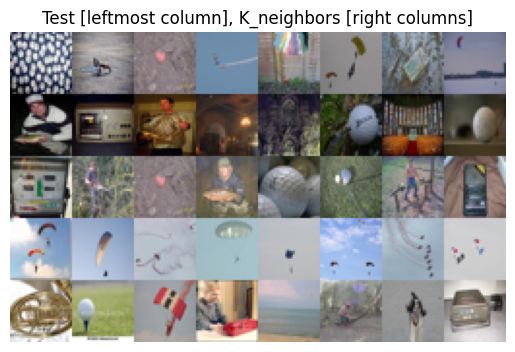

In [ ]:
def visualize_knn(classifier,X_test,N=5, K=7):
  # This visualization routine makes use of GLOBAL Train_Images and Test_Images variables
  # to visualize the K nearest neighbors of the first N Test Images

  dist = classifier.compute_distances_no_loops(X_test[:N,:])
  _, k_idxs = classifier.predict_labels(dist,k=K)
  k_idxs  = np.vstack(k_idxs)
  testim  = montage(Test_Images[:N,:],grid_shape=(N,1),channel_axis=3)
  trainim = montage(Train_Images[k_idxs.ravel(),:],grid_shape=(N,K),channel_axis=3)
  plt.imshow(np.concatenate((testim,trainim),axis=1))
  plt.axis('off');
  plt.title('Test [leftmost column], K_neighbors [right columns]');

visualize_knn(classifier,X_test)



### Normalizing image descriptors:

Let us try normalizing each image here by subtracting by its mean and scaling to have unit norm.

In [ ]:
# Normalize each image descriptor to have zero-mean and unit-length

X_train_norm = X_train
X_test_norm  = X_test

# ===== your code here! =====
# Normalize each image descriptor to have zero-mean and unit-length
# If X is the descriptor vector for a given image, then sum_i X[i] = 0 and sum_i X[i]**2 = 1

# ===== end of code =====

print('Train data shape: ', X_train_norm.shape)
print('Test data shape: ', X_test_norm.shape)

Train data shape:  (1900, 3072)
Test data shape:  (700, 3072)


We calculate the accuracies again using k = 1 and k = 3 and see that the accuracies are much better compared to those we obtained without any preprocessing on the images!

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train_norm,y_train)

# Classify using the efficient no_loops implementation
dists = classifier.compute_distances_no_loops(X_test_norm)
y_test_pred, k_labels = classifier.predict_labels(dists, k=3)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 204 / 700 correct => accuracy: 0.291429


Written question: Normalization produces image descriptors that have unit length. Prove that minimizing the euclidean distance of such descriptors is equivalent to maximizing the cosine similarity. Here is an example of latex in markdown that might be helpful: $||x - y||^2 = x^Tx - 2x^Ty + y^Ty$    


===== your answer here! =====


===== end of your answer =====


## KNN with HOG
The previous parts all directly used raw pixels from input images to compute distances with k-NN. In this part, we will first use the Histogram of Oriented Gradients (HOG) as features for each image. We will use these features with our kNN implementation to find the nearest neighbours. Please read the descriptions and fill in the functions below.

In [ ]:
def compute_gradient(image):
  """
    Computes the gradients in both x and y directions.
    Computes the magnitudes of the gradients.
    Computes the angles from the gradients and map to range [0, 180 deg].
    NOTE: You may *NOT* use np.gradient
    Inputs:
    - image: A (32,32) numpy array corresponding to a grayscale image
             or a (32,32,3) array corresponding to a color image
    Returns:
    - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
      is the magnitude of the gradient at the (i, j) pixel in the input image.
    - angles: A numpy array of shape (32, 32) where angles[i, j]
      is the angle of the gradient at the (i, j) pixel in the input image.
    HINT: First write thefunction assuming a grayscale input and get a final accuracy. Then write the color version.
          You may wish to use numpy.take_along_axis()
    """

  # ===== your code here! =====

  # TODO:
  # Compute the gradients along the rows and columns as two arrays.
  # Compute the magnitude as the square root of the sum of the squares of both gradients
  # Compute the angles as the inverse tangent of the gradients along the rows and
  # the gradients along the columns, and map them to the range [0, 180 deg]


  # ==== end of code ====
  return magnitudes, angles

In [ ]:
def bin_gradient(angles, magnitudes, n_orient, pixels_per_cell):
  """
  Given the gradient orientations and magnitudes of an image, creates
  a histogram of orientations weighted by gradient magnitudes
  Inputs:
  - angles: A numpy array of shape (32, 32) where angles[i,j]
      is the angle of the gradient at the (i,j) pixel in the input image.
  - magnitudes: A numpy array of shape (32, 32) where magnitudes[i,j]
      is the magnitude of the gradient at the (i,j) pixel in the input image.
  - n_orient: An int representing the number of orientations to bin in histogram
  - pixels_per_cell: An int representing the number of rows/columns of pixels
      in each spatial cell
  Returns:
  - oriented_histogram: A numpy array of shape (32/4=8, 32/4=8,9)
      for pixels_per_cell=4 and n_orient=9
   """

  n_y,n_x = angles.shape
  oriented_histogram = np.zeros((int(n_y//pixels_per_cell),int(n_x//pixels_per_cell),n_orient))

  # ===== your code here! =====

  # TODO:
  # Iterate through each pixel in every cell
  # Find the index to the bin in histogram for that pixel's orientation
  # Add the weighted magnitude to the corresponding bins in the histogram

  # ==== end of code ====
  return oriented_histogram


**NOTE :** Once we create a histogram based on the gradient of the image we need to normalize it. Gradients of an image are sensitive to overall lighting. If you make the image darker by dividing all pixel values by 2, the gradient magnitude will change by half, and therefore the histogram values will change by half.

Ideally, we want our image features to be independent of lighting variations. In other words, we would like to “normalize” the histogram so they are not affected by lighting variations.

We have provided the normalization code below.

In [ ]:
def block_normalize(oriented_histogram, cells_per_block, clip = True, epsilon=1e-5):
  """
  Normalizes the histogram in blocks of size cells_per_block.
  Inputs:
  - oriented_histogram: A numpy array of shape (num_cell_rows, num_cell_cols, num_orient)
    representing the histogram of oriented gradients of the input image.
  - cells_per_block: An int representing the number of rows/columns of cells that
    should together be normalized in the same block (you can assume )
  - clip: If true, this clips the normalized descriptor of each block to ensure that no values are larger than .2 (and then
    renormalizes to ensure the clipped descriptor is unit-norm), just as SIFT does
  - epsilon: A float indicating the small amount added to the denominator when
    normalizing to avoid dividing by zero.
  Returns:
  - normalized_blocks: A numpy array of k,num_orient) where normalized_blocks[i,j] is a normalized [cells_per_block,cells_per_block,num_orient] "SIFT" descriptor
  """shape (num_cell_rows-cells_per_block+1, num_cell_cols+cells_per_block+1,
      cells_per_block,cells_per_bloc

  n_blocks_y = oriented_histogram.shape[0]-cells_per_block+1
  n_blocks_x = oriented_histogram.shape[1]-cells_per_block+1
  normalized_blocks = np.zeros((n_blocks_y,n_blocks_x,cells_per_block,cells_per_block,oriented_histogram.shape[2]))
  # ===== your code here! =====

  # TODO:
  # While there are many ways to compute the descriptor, we suggest iterating through the first dimension (n_blocks_y)
  # and second dimension (n_blocks_x) of normalized blocks and compute the [4 4 9] "SIFT" descriptor
  # (assuming cells_per_block = 4 and n_orient = 9).

  # ==== end of code ====
  return normalized_blocks

After implementing your HOG functions, please run the cells below to test the results. You should expect to get an accuracy slightly higher than that with unnormalized raw pixels.

In [ ]:
def compute_hog(image,n_orient=9,pixels_per_cell=4,cells_per_block=4):
  """
  Builds a Histogram of Oriented Gradients (HOG) weighted by gradient magnitudes
  from an input image
  Inputs:
  - image: A numpy array of shape (32, 32) containing one grayscaled image.
  Outputs:
  - histogram: A 1D numpy array that represents the HOG descriptor for the image.
  """
  assert(image.dtype == 'float64')
  # Read in image and convert to grayscale
  # if len(image.shape) > 2:
  #  image = np.mean(image,2)

  # Compute gradient
  magnitudes, angles = compute_gradient(image)

  # Bin gradients into cells
  oriented_histogram = bin_gradient(angles, magnitudes, n_orient, pixels_per_cell)

  # Block normalize the cells
  normalized_blocks = block_normalize(oriented_histogram, cells_per_block)

  # Return flattened descriptor (without making an additional copy)
  return normalized_blocks.ravel()

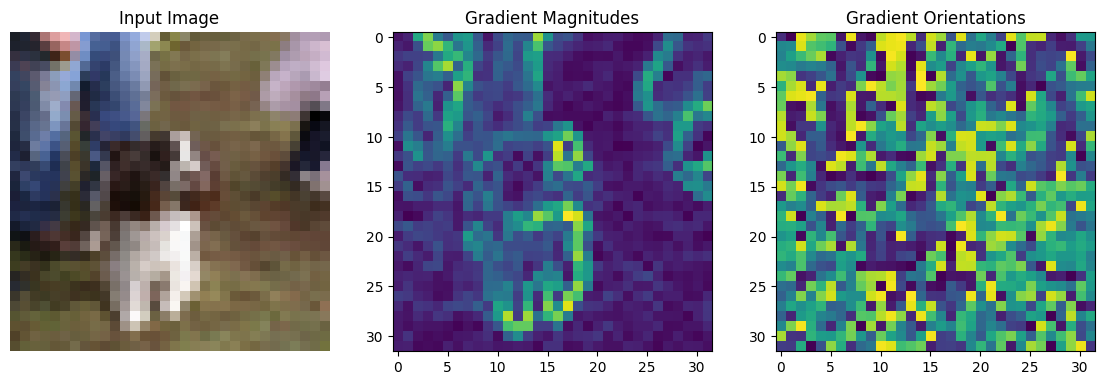

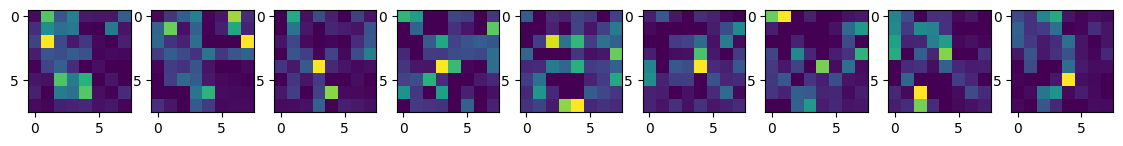

In [ ]:
# Check out HOG descriptor for a single image
#image = X_train[0].mean(2) # Initially, build representation for grayscale image
image = X_train[0].reshape(img_size,img_size,3);
plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
plt.imshow(image.astype('uint8'));
plt.axis('off')
plt.title('Input Image')

pixels_per_cell=4
cells_per_block=4
n_orient=9
angle_step = 180 // n_orient

# Step 1: compute gradients
magnitudes, angles = compute_gradient(image)

plt.subplot(1,3,2)
plt.imshow(magnitudes)
plt.title('Gradient Magnitudes')

plt.subplot(1,3,3)
plt.imshow(angles)
plt.title('Gradient Orientations')


# Step 2: Bin gradients into cells
oriented_histogram = bin_gradient(angles, magnitudes, n_orient, pixels_per_cell)
plt.figure(figsize=(14,8))
#plt.suptitle('Oriented Histograms')
for i in range(n_orient):
  plt.subplot(1,n_orient,i+1)
  plt.imshow(oriented_histogram[:,:,i])

# Step 3: Block normalize the cells
normalized_blocks = block_normalize(oriented_histogram, cells_per_block)


This part will take some time to run for the full dataset. Approx 1 to 2mins.

In [ ]:
X_train_hog = np.array([compute_hog(X_train[i].reshape(img_size,img_size,3)) for i in range(num_train)])
X_test_hog  = np.array([compute_hog( X_test[i].reshape(img_size,img_size,3)) for i in range(num_test)])
print('Train data shape: ', X_train_hog.shape)
print('Test data shape: ' , X_test_hog.shape)

Train data shape:  (1900, 3600)
Test data shape:  (700, 3600)


In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train_hog,y_train)
dists = classifier.compute_distances_no_loops(X_test_hog)

In [ ]:
# Compute and print the fraction of correctly predicted examples
y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 252 / 700 correct => accuracy: 0.360000


You can also visualize the K nearest images for some randomly selected examples from the test set using the k_idxs list you returned in predict_labels trained with HOG descriptors.

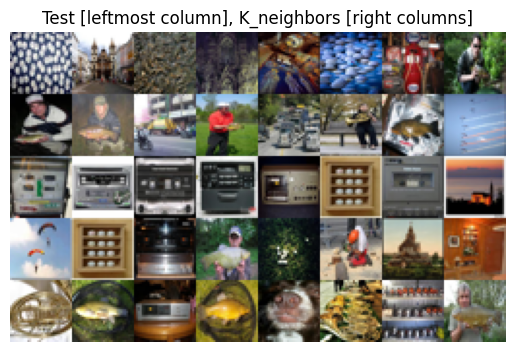

In [ ]:
visualize_knn(classifier,X_test_hog)

### Extra credit 1: parameter tweaking
Add in descriptions of your optimal parameter settings and the resulting performance, compared to your default parameter settings and your default performance


 # ===== your answers here! =====


 # ==== end of answer ====




### Extra credit 2: low-rank descriptors

Reducing dimensionality from 3600 to 400
Got 247 / 700 correct => accuracy: 0.352857


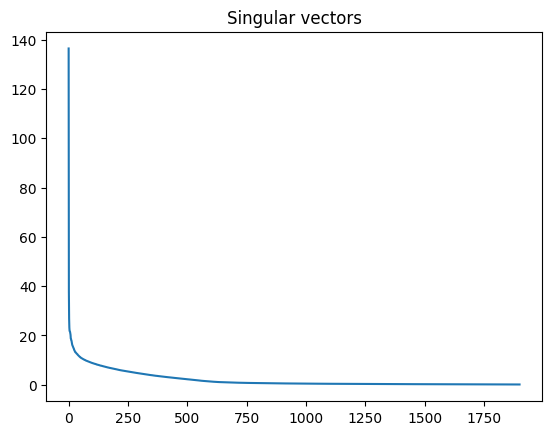

In [ ]:
# ===== your code here! =====

# ===== end of code =====